In [9]:
import sys
print(sys.executable)
print(sys.path)
!where pip


c:\Users\sapta\Desktop\practice\TIME_SERIES_DATA\myvenv\Scripts\python.exe
['C:\\Users\\sapta\\AppData\\Local\\Programs\\Python\\Python313\\python313.zip', 'C:\\Users\\sapta\\AppData\\Local\\Programs\\Python\\Python313\\DLLs', 'C:\\Users\\sapta\\AppData\\Local\\Programs\\Python\\Python313\\Lib', 'C:\\Users\\sapta\\AppData\\Local\\Programs\\Python\\Python313', 'c:\\Users\\sapta\\Desktop\\practice\\TIME_SERIES_DATA\\myvenv', '', 'c:\\Users\\sapta\\Desktop\\practice\\TIME_SERIES_DATA\\myvenv\\Lib\\site-packages']
c:\Users\sapta\Desktop\practice\TIME_SERIES_DATA\myvenv\Scripts\pip.exe
C:\Users\sapta\Desktop\practice\myvenv\Scripts\pip.exe
C:\Users\sapta\AppData\Local\Programs\Python\Python313\Scripts\pip.exe


In [10]:
!{sys.executable} -m pip show scikit-learn


In [18]:
from sklearn.metrics import mean_squared_error


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import numpy as np

from arch import arch_model

# Load data
dataset = pd.read_csv(r"C:\Users\sapta\Desktop\practice\datasets\Tomato.csv")

# Preprocessing
series = dataset["Average"][500:1500].copy()
series = series.interpolate(method = "linear")

# Validation set
orseries = dataset["Average"][1500:1525].copy()

print("Data loaded. Series shape:", series.shape)
print("Validation set shape:", orseries.shape)

Data loaded. Series shape: (1000,)
Validation set shape: (25,)


Original Series Stationarity:
ADF Statistic: -3.717031
p-value: 0.003880
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Data is stationary

Differenced Series Stationarity:
ADF Statistic: -10.985980
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Data is stationary


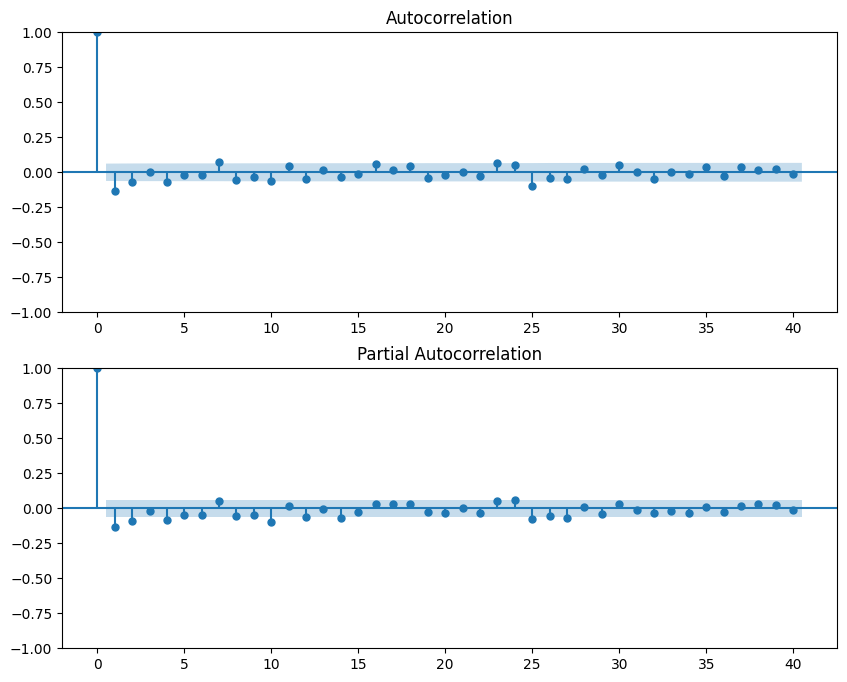

In [12]:
# Stationarity Check (ADF Test)
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary")

print("Original Series Stationarity:")
check_stationarity(series)

# Check Differencing
series_diff = series.diff().dropna()
print("\nDifferenced Series Stationarity:")
check_stationarity(series_diff)

# Plot ACF/PACF for differenced series
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(series_diff, lags=40, ax=ax[0])
plot_pacf(series_diff, lags=40, ax=ax[1])
plt.show()

In [16]:
# Model Fitting with Seasonality s=7 (Weekly)
# Using d=1 based on non-stationarity assumption (to be refined by ADF results)
# Using p=1, q=1 as starting point, seasonal P=1, Q=1, D=0 (can be tuned)

order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)

model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           Average   No. Observations:                 1000
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3200.952
Date:                           Tue, 17 Feb 2026   AIC                           6411.903
Time:                                   22:50:41   BIC                           6436.402
Sample:                                        0   HQIC                          6421.218
                                          - 1000                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8271      0.032     26.051      0.000       0.765       0.889
ma.L1         -0.9411      0.021    -44.691

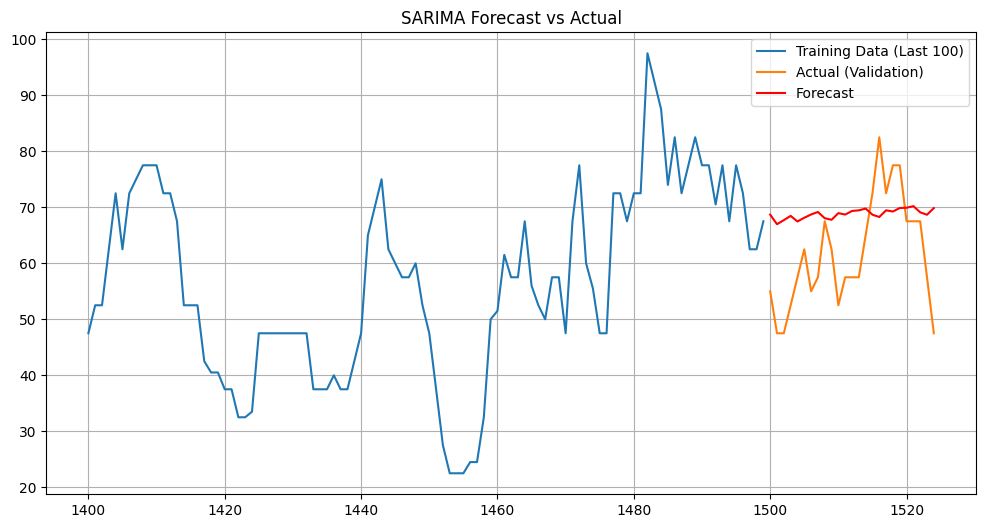

In [17]:
# Forecasting with Index Alignment
forecast_steps = len(orseries)
# Get forecast starting from the end of training data
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean

# Align Forecast Index with Validation Data Index
# The model forecast index should naturally follow, but explicitly setting it ensures plotting alignment
forecast_values.index = orseries.index

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(series[-100:], label='Training Data (Last 100)')
plt.plot(orseries, label='Actual (Validation)')
plt.plot(forecast_values, label='Forecast', color='red')
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Evaluation
rmse = np.sqrt(mean_squared_error(orseries, forecast_values))
print(f"RMSE: {rmse}")

RMSE: 11.297707609797255


In [26]:
lreturns = np.log(series/series.shift(1)).dropna()

model = arch_model(lreturns, vol="Garch", p=1, q=1)
result= model.fit()
print(result.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 29520162804943.77
Iteration:      2,   Func. Count:     16,   Neg. LLF: 283553.4446832053
Iteration:      3,   Func. Count:     24,   Neg. LLF: -191.75066764992877
Iteration:      4,   Func. Count:     32,   Neg. LLF: -535.2315480058537
Iteration:      5,   Func. Count:     38,   Neg. LLF: -268.94815497172084
Iteration:      6,   Func. Count:     44,   Neg. LLF: -555.8498678209752
Iteration:      7,   Func. Count:     50,   Neg. LLF: -579.2315898212562
Iteration:      8,   Func. Count:     56,   Neg. LLF: -576.128179308394
Iteration:      9,   Func. Count:     62,   Neg. LLF: -579.6270869068005
Iteration:     10,   Func. Count:     67,   Neg. LLF: -579.6276126703893
Iteration:     11,   Func. Count:     72,   Neg. LLF: -579.6276331199122
Iteration:     12,   Func. Count:     77,   Neg. LLF: -579.6276370938082
Iteration:     13,   Func. Count:     81,   Neg. LLF: -579.6276370936162
Optimization terminated successfully    (Exit mode 0

c:\Users\sapta\Desktop\practice\TIME_SERIES_DATA\myvenv\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
